<a href="https://colab.research.google.com/github/jhanv/Cypto_RoboAdvisor/blob/main/Transformers_Bitcoin_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cyptocurrency Time Series Transformers

The central goal is to analyse the cryptomarket  and see if a deep learning model can predict the fluctuation of prices in conjunction with sentiment data. To this end, we hope to construct a few models (In this notebook we are exploring with Transformers) of varying complexity to help learn the patterns (if any) and help eliminate some of the uncertainty of this market. We believe that crypto currencies would have a prominent position in the future of finance and this paper would shed light into how people view the currency.  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import
import pandas as pd
import numpy as np
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from sklearn import preprocessing

import matplotlib.pyplot as plt
plt.style.use('seaborn')


%matplotlib inline

## Hyperparameters

In [4]:
batch_size = 32
seq_len = 30
prediction_date = 1

kernel_num = 1

feature_num = 5

d_k = 64
d_v = 64
n_heads = 12
ff_dim = 64

## Loading data



In [5]:
# from datapackage import Package

# coin = 'bitcoin'
# package = Package('https://datahub.io/cryptocurrency/' + coin + '/datapackage.json')

# # print list of all resources:
# print(package.resource_names)

# # print processed tabular data (if exists any)
# for resource in package.resources:
#     if resource.descriptor['datahub']['type'] == 'derived/csv':
#         print(resource.read())


In [6]:
# cpt_df = pd.DataFrame.from_records(resource.read(), columns = resource.headers)
# cpt_df.head()

In [7]:
cpt_df = pd.read_csv("/content/drive/MyDrive/CIS 522 Final Project/Data/Bitstamp_BTCUSD_d.csv", skiprows=1)
# cpt_df = pd.read_csv("Bitstamp_BTCUSD_d.csv", skiprows=1)
cpt_df = cpt_df[pd.to_datetime(cpt_df["date"]) < "2019-10-01"] # Date selection
cpt_df["date"] = pd.to_datetime(cpt_df["date"])
cpt_df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
579,1569801600,2019-09-30,BTC/USD,8060.13,8368.50,7714.70,8298.45,9518.992108,7.899288e+07
580,1569715200,2019-09-29,BTC/USD,8218.07,8244.07,7902.66,8047.60,5366.570718,4.318801e+07
581,1569628800,2019-09-28,BTC/USD,8199.96,8356.40,8009.84,8218.07,6315.489539,5.190114e+07
582,1569542400,2019-09-27,BTC/USD,8055.25,8294.04,7866.00,8187.72,10165.852937,8.323516e+07
583,1569456000,2019-09-26,BTC/USD,8443.44,8467.89,7733.99,8055.03,16662.320212,1.342155e+08


In [8]:
cpt_full_df = cpt_df[["date", "open", "close", "high", "low", "Volume USD"]].sort_values("date").reset_index(drop=True)
cpt_full_df.columns = ["date", "open", "close", "high", "low", "Volume USDT"]
cpt_full_df.head()

,date,open,close,high,low,Volume USDT
0,2014-11-28,363.59,376.28,381.34,360.57,8617.15
1,2014-11-29,376.42,376.72,386.60,372.25,7245.19
2,2014-11-30,376.57,373.34,381.99,373.32,3046.33
3,2014-12-01,376.40,378.39,382.31,373.03,6660.56
4,2014-12-02,378.39,379.25,382.86,375.23,6832.53


## Plotting (Without normalizations)

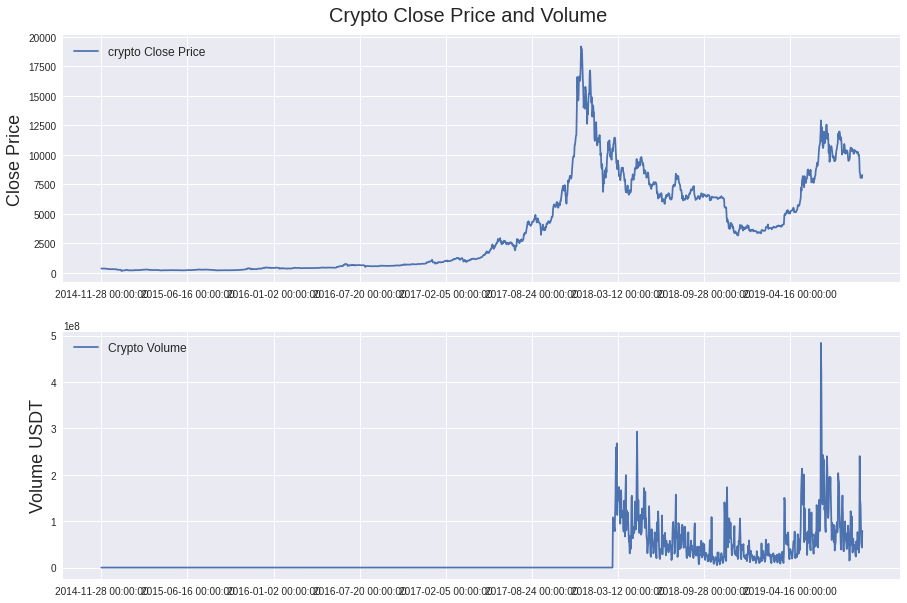

In [9]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Crypto Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(cpt_full_df['close'], label='crypto Close Price')
ax1.set_xticks(range(0, cpt_full_df.shape[0], 200))
ax1.set_xticklabels(cpt_full_df['date'].loc[::200])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(cpt_full_df['Volume USDT'], label='Crypto Volume')
ax2.set_xticks(range(0, cpt_full_df.shape[0], 200))
ax2.set_xticklabels(cpt_full_df['date'].loc[::200])
ax2.set_ylabel('Volume USDT', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## NLP data

### Reddit data

In [10]:
reddit_df = pd.read_csv("/content/drive/MyDrive/CIS 522 Final Project/Data/reddit_data.csv", header=None)
# reddit_df = pd.read_csv("output.csv", header=None)
reddit_df.columns = ['row', 'date', 'reddit_sentiment_label', 'reddit_sentiment_score', 'reddit_likes']
reddit_df["date"] = pd.to_datetime(reddit_df["date"])

In [11]:
reddit_df["const"] = 1
reddit_df["weighted_score"] = reddit_df["reddit_sentiment_label"] * reddit_df["reddit_sentiment_score"] *\
reddit_df["reddit_likes"]

In [12]:
reddit_grp_df = reddit_df.groupby("date").agg({"weighted_score": np.mean, "const": np.sum, "reddit_likes":np.sum})
reddit_grp_df = reddit_grp_df.reset_index()
reddit_grp_df["date"] = pd.to_datetime(reddit_grp_df["date"])
reddit_grp_df.columns = ["date", "reddit_weighted_score", "reddit_posts", "reddit_likes_total"]
reddit_grp_df

,date,reddit_weighted_score,reddit_posts,reddit_likes_total
0,2009-05-08,-0.000278,4,2.0
1,2009-07-18,0.000000,1,0.0
2,2009-09-24,-0.986288,2,2.0
3,2009-12-31,-0.999489,1,1.0
4,2010-03-28,-1.944747,1,2.0
...,...,...,...,...
3303,2019-12-27,-2.773279,873,3113.0
3304,2019-12-28,-3.787780,763,3530.0
3305,2019-12-29,-3.141962,866,3440.0
3306,2019-12-30,-4.134217,1017,5217.0


In [13]:
cpt_full_df = cpt_full_df.merge(reddit_grp_df, how="left", left_on="date", right_on="date")
cpt_full_df.head()

,date,open,close,high,low,Volume USDT,reddit_weighted_score,reddit_posts,reddit_likes_total
0,2014-11-28,363.59,376.28,381.34,360.57,8617.15,-3.285267,1202,5356.0
1,2014-11-29,376.42,376.72,386.60,372.25,7245.19,-1.696123,1076,2577.0
2,2014-11-30,376.57,373.34,381.99,373.32,3046.33,-2.324880,1005,3141.0
3,2014-12-01,376.40,378.39,382.31,373.03,6660.56,-2.131355,1287,3599.0
4,2014-12-02,378.39,379.25,382.86,375.23,6832.53,-1.606622,1447,4560.0


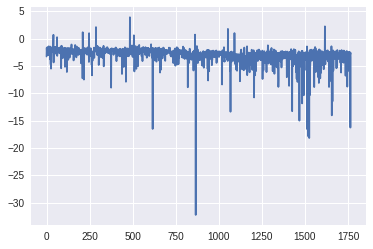

In [14]:
plt.plot(cpt_full_df["reddit_weighted_score"])

### Google Trends

In [15]:
google_df = pd.read_csv("/content/drive/MyDrive/CIS 522 Final Project/Data/goole_trends_bitcoin.csv")
google_df["date"] = pd.to_datetime(google_df["date"])
google_df.head()

,date,bitcoin_unscaled,bitcoin_monthly,isPartial,scale,bitcoin
0,2014-01-01,47,8.0,False,0.08,3.76
1,2014-01-02,52,8.0,NaN,0.08,4.16
2,2014-01-03,50,8.0,NaN,0.08,4.00
3,2014-01-04,44,8.0,NaN,0.08,3.52
4,2014-01-05,50,8.0,NaN,0.08,4.00


In [16]:
google_req_df = google_df[["date", "bitcoin"]]
google_req_df.columns = ["date", "google_trends"] 
google_req_df.head()

,date,google_trends
0,2014-01-01,3.76
1,2014-01-02,4.16
2,2014-01-03,4.00
3,2014-01-04,3.52
4,2014-01-05,4.00


In [17]:
# Merging
cpt_full_df = cpt_full_df.merge(google_req_df, how="left", left_on="date", right_on="date")
cpt_full_df.head()

,date,open,close,high,low,Volume USDT,reddit_weighted_score,reddit_posts,reddit_likes_total,google_trends
0,2014-11-28,363.59,376.28,381.34,360.57,8617.15,-3.285267,1202,5356.0,1.89
1,2014-11-29,376.42,376.72,386.60,372.25,7245.19,-1.696123,1076,2577.0,1.89
2,2014-11-30,376.57,373.34,381.99,373.32,3046.33,-2.324880,1005,3141.0,1.44
3,2014-12-01,376.40,378.39,382.31,373.03,6660.56,-2.131355,1287,3599.0,0.63
4,2014-12-02,378.39,379.25,382.86,375.23,6832.53,-1.606622,1447,4560.0,0.63


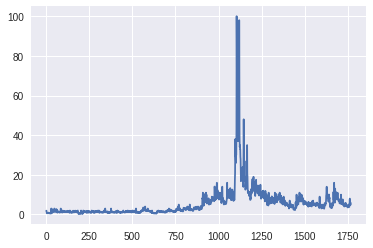

In [18]:
plt.plot(cpt_full_df["google_trends"])

In [19]:
# from pytrends import dailydata as dd

# df_daily_bitcoin = dd.get_daily_data("bitcoin",2014,1,2020,3,"US",True)
# df_daily_bitcoin.head(50)

### Twitter counts

In [20]:
# twitter_df = pd.read_csv("/content/drive/MyDrive/CIS 522 Final Project/Data/twitter_data.csv")
# twitter_df.head()

In [21]:
twitter_df = pd.read_csv("/content/drive/MyDrive/CIS 522 Final Project/Data/bitcoin_daily_tweet_count.csv").T.reset_index()
twitter_df = twitter_df.loc[1:,:]
twitter_df.columns = ["date", "twitter_posts"]
twitter_df["twitter_posts"] = twitter_df["twitter_posts"].astype(float)
twitter_df["date"] = pd.to_datetime(twitter_df["date"])
twitter_df.head()

,date,twitter_posts
1,2014-04-09,8193.0
2,2014-04-10,15039.0
3,2014-04-11,14907.0
4,2014-04-12,7582.0
5,2014-04-13,10674.0


Text(0.5, 0, '12')

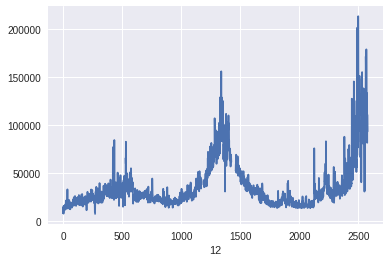

In [22]:
# Filling nans
# plt.plot(twitter_df["twitter_posts"].interpolate(model="time"))
plt.plot(twitter_df["twitter_posts"])
plt.xlabel("12")

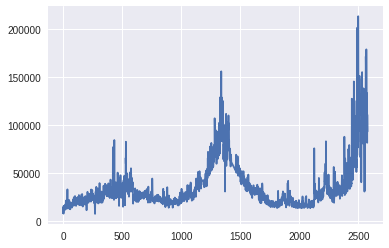

In [23]:
plt.plot(twitter_df["twitter_posts"].interpolate(model="piecewise_polynomial"))

In [24]:
twitter_df["twitter_posts"] = twitter_df["twitter_posts"].interpolate(model="piecewise_polynomial")

In [25]:
cpt_full_df = cpt_full_df.merge(twitter_df, how="left", left_on="date", right_on="date")
cpt_full_df.head()

,date,open,close,high,low,Volume USDT,reddit_weighted_score,reddit_posts,reddit_likes_total,google_trends,twitter_posts
0,2014-11-28,363.59,376.28,381.34,360.57,8617.15,-3.285267,1202,5356.0,1.89,24830.0
1,2014-11-29,376.42,376.72,386.60,372.25,7245.19,-1.696123,1076,2577.0,1.89,26555.0
2,2014-11-30,376.57,373.34,381.99,373.32,3046.33,-2.324880,1005,3141.0,1.44,20117.0
3,2014-12-01,376.40,378.39,382.31,373.03,6660.56,-2.131355,1287,3599.0,0.63,26508.0
4,2014-12-02,378.39,379.25,382.86,375.23,6832.53,-1.606622,1447,4560.0,0.63,32744.0


In [26]:
# cpt_full_df.to_csv("/content/drive/MyDrive/CIS 522 Final Project/Data/bitcoin_complete.csv")

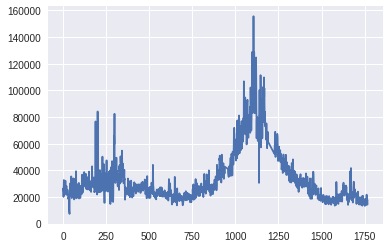

In [27]:
plt.plot(cpt_full_df["twitter_posts"].interpolate(method='linear'))

## Cleaning data

### Percentage Change of prices and volume

In [28]:
cpt_full_df.columns

Index(['date', 'open', 'close', 'high', 'low', 'Volume USDT',
       'reddit_weighted_score', 'reddit_posts', 'reddit_likes_total',
       'google_trends', 'twitter_posts'],
      dtype='object')

In [29]:
scaler = preprocessing.StandardScaler()
cols = list(col for col in cpt_full_df.columns if col != "date" )
cpt_full_df[cols] = scaler.fit_transform(cpt_full_df[cols])
cpt_full_df.head()

,date,open,close,high,low,Volume USDT,reddit_weighted_score,reddit_posts,reddit_likes_total,google_trends,twitter_posts
0,2014-11-28,-0.838233,-0.835993,-0.831972,-0.845152,-0.491784,-0.162504,-0.342811,-0.278315,-0.476937,-0.486911
1,2014-11-29,-0.834964,-0.835880,-0.830680,-0.842026,-0.491815,0.782577,-0.414761,-0.547542,-0.476937,-0.396943
2,2014-11-30,-0.834926,-0.836741,-0.831812,-0.841740,-0.491910,0.408648,-0.455304,-0.492902,-0.537178,-0.732720
3,2014-12-01,-0.834969,-0.835455,-0.831733,-0.841817,-0.491828,0.523740,-0.294273,-0.448531,-0.645613,-0.399394
4,2014-12-02,-0.834462,-0.835236,-0.831598,-0.841229,-0.491824,0.835804,-0.202908,-0.355431,-0.645613,-0.074153


### Adding percentage change

In [30]:
cpt_full_df["open_dt"] = cpt_full_df["open"].pct_change()
cpt_full_df["close_dt"] = cpt_full_df["close"].pct_change()
cpt_full_df["low_dt"] = cpt_full_df["low"].pct_change()
cpt_full_df["high_dt"] = cpt_full_df["high"].pct_change()

cpt_full_df["Volume USDT_dt"] = cpt_full_df["Volume USDT"].pct_change()

cpt_full_df.dropna(how="any", axis=0, inplace=True)
cpt_full_df.head()

,date,open,close,high,low,Volume USDT,reddit_weighted_score,reddit_posts,reddit_likes_total,google_trends,twitter_posts,open_dt,close_dt,low_dt,high_dt,Volume USDT_dt
1,2014-11-29,-0.834964,-0.835880,-0.830680,-0.842026,-0.491815,0.782577,-0.414761,-0.547542,-0.476937,-0.396943,-0.003900,-0.000134,-0.003699,-0.001552,0.000063
2,2014-11-30,-0.834926,-0.836741,-0.831812,-0.841740,-0.491910,0.408648,-0.455304,-0.492902,-0.537178,-0.732720,-0.000046,0.001030,-0.000340,0.001362,0.000194
3,2014-12-01,-0.834969,-0.835455,-0.831733,-0.841817,-0.491828,0.523740,-0.294273,-0.448531,-0.645613,-0.399394,0.000052,-0.001538,0.000092,-0.000094,-0.000167
4,2014-12-02,-0.834462,-0.835236,-0.831598,-0.841229,-0.491824,0.835804,-0.202908,-0.355431,-0.645613,-0.074153,-0.000607,-0.000262,-0.000699,-0.000162,-0.000008
5,2014-12-03,-0.834243,-0.835893,-0.831564,-0.841496,-0.491800,0.675420,-0.257727,-0.453569,-0.641596,-0.478566,-0.000263,0.000787,0.000318,-0.000041,-0.000050


In [31]:
cpt_full_df


,date,open,close,high,low,Volume USDT,reddit_weighted_score,reddit_posts,reddit_likes_total,google_trends,twitter_posts,open_dt,close_dt,low_dt,high_dt,Volume USDT_dt
1,2014-11-29,-0.834964,-0.835880,-0.830680,-0.842026,-0.491815,0.782577,-0.414761,-0.547542,-0.476937,-0.396943,-0.003900,-0.000134,-0.003699,-0.001552,0.000063
2,2014-11-30,-0.834926,-0.836741,-0.831812,-0.841740,-0.491910,0.408648,-0.455304,-0.492902,-0.537178,-0.732720,-0.000046,0.001030,-0.000340,0.001362,0.000194
3,2014-12-01,-0.834969,-0.835455,-0.831733,-0.841817,-0.491828,0.523740,-0.294273,-0.448531,-0.645613,-0.399394,0.000052,-0.001538,0.000092,-0.000094,-0.000167
4,2014-12-02,-0.834462,-0.835236,-0.831598,-0.841229,-0.491824,0.835804,-0.202908,-0.355431,-0.645613,-0.074153,-0.000607,-0.000262,-0.000699,-0.000162,-0.000008
5,2014-12-03,-0.834243,-0.835893,-0.831564,-0.841496,-0.491800,0.675420,-0.257727,-0.453569,-0.641596,-0.478566,-0.000263,0.000787,0.000318,-0.000041,-0.000050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,2019-09-26,1.220494,1.120198,1.153181,1.128187,2.555181,-0.283469,-0.300554,-0.095117,0.308876,-0.758693,-0.019100,-0.078992,-0.102610,-0.056052,-0.102164
1764,2019-09-27,1.121584,1.154001,1.110503,1.163517,1.397749,-7.879117,1.112177,5.516301,0.116104,-0.784771,-0.081041,0.030176,0.031315,-0.037009,-0.452974
1765,2019-09-28,1.158456,1.161733,1.125811,1.202012,0.686357,0.005126,-0.455875,-0.451922,-0.033829,-0.978006,0.032875,0.006700,0.033086,0.013785,-0.508955
1766,2019-09-29,1.163070,1.118305,1.098236,1.173328,0.488539,0.081178,-0.473577,-0.457638,-0.087377,-1.039811,0.003983,-0.037382,-0.023864,-0.024494,-0.288215


### Normalising price columns

In [32]:
# cpt_full_df = cpt_full_df.drop(columns=["open", "low"])

In [33]:
# min_return = min(cpt_full_df[['open', 'high', 'low', 'close']].min(axis=0))
# max_return = max(cpt_full_df[['open', 'high', 'low', 'close']].max(axis=0))

# # Min-max normalize price columns (0-1 range)
# cpt_full_df['open'] = (cpt_full_df['open'] - min_return) / (max_return - min_return)
# cpt_full_df['high'] = (cpt_full_df['high'] - min_return) / (max_return - min_return)
# cpt_full_df['low'] = (cpt_full_df['low'] - min_return) / (max_return - min_return)
# cpt_full_df['close'] = (cpt_full_df['close'] - min_return) / (max_return - min_return)

### Normalising volume columns

In [34]:
# min_volume = cpt_full_df['Volume USDT'].min(axis=0)
# max_volume = cpt_full_df['Volume USDT'].max(axis=0)

# # Min-max normalize volume columns (0-1 range)
# cpt_full_df['Volume USDT'] = (cpt_full_df['Volume USDT'] - min_volume) / (max_volume - min_volume)

### Test Train split

In [35]:
per_of_test = 0.1
per_of_val = 0.1

times = sorted(cpt_full_df.index.values)
last_npct = sorted(cpt_full_df.index.values)[-int(per_of_test*len(times))] # Last 10% of series
last_2npct = sorted(cpt_full_df.index.values)[-int((per_of_val+per_of_test)*len(times))] # Last 20% of series

df_train = cpt_full_df[(cpt_full_df.index < last_2npct)]  # Training data are 80% of total data
df_val = cpt_full_df[(cpt_full_df.index >= last_2npct) & (cpt_full_df.index < last_npct)]
df_test = cpt_full_df[(cpt_full_df.index >= last_npct)]

# Remove date column
df_train.drop(columns=['date'], inplace=True)
df_val.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values

feature_num=train_data.shape[1]

print(f'Training data shape: {train_data.shape}')
print(f'Validation data shape: {val_data.shape}')
print(f'Test data shape: {test_data.shape}')

df_train.head()

Training data shape: (1414, 15)
Validation data shape: (177, 15)
Test data shape: (176, 15)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,open,close,high,low,Volume USDT,reddit_weighted_score,reddit_posts,reddit_likes_total,google_trends,twitter_posts,open_dt,close_dt,low_dt,high_dt,Volume USDT_dt
1,-0.834964,-0.835880,-0.830680,-0.842026,-0.491815,0.782577,-0.414761,-0.547542,-0.476937,-0.396943,-0.003900,-0.000134,-0.003699,-0.001552,0.000063
2,-0.834926,-0.836741,-0.831812,-0.841740,-0.491910,0.408648,-0.455304,-0.492902,-0.537178,-0.732720,-0.000046,0.001030,-0.000340,0.001362,0.000194
3,-0.834969,-0.835455,-0.831733,-0.841817,-0.491828,0.523740,-0.294273,-0.448531,-0.645613,-0.399394,0.000052,-0.001538,0.000092,-0.000094,-0.000167
4,-0.834462,-0.835236,-0.831598,-0.841229,-0.491824,0.835804,-0.202908,-0.355431,-0.645613,-0.074153,-0.000607,-0.000262,-0.000699,-0.000162,-0.000008
5,-0.834243,-0.835893,-0.831564,-0.841496,-0.491800,0.675420,-0.257727,-0.453569,-0.641596,-0.478566,-0.000263,0.000787,0.000318,-0.000041,-0.000050


### Plotting the Train Test Validation split

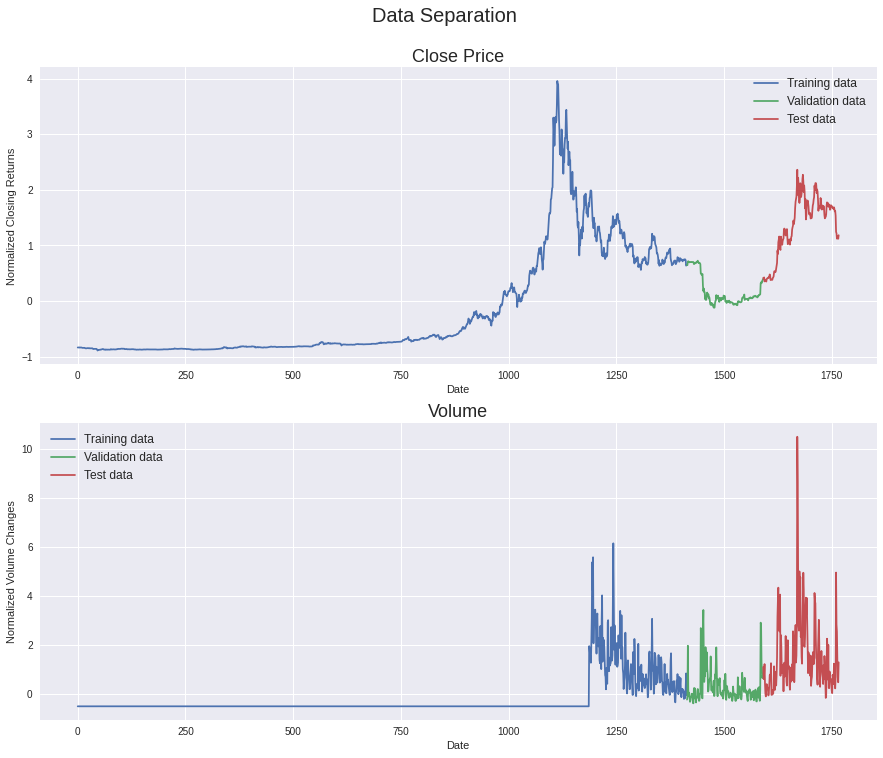

In [36]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume USDT'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume USDT'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume USDT'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

### Creating data chunks

Were predicting closing price for the next day is this chunking

In [37]:
closing_index=1

# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)-prediction_date+1):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, closing_index][i+prediction_date-1]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)-prediction_date+1):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, closing_index][i+prediction_date-1])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)-prediction_date+1):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, closing_index][i+prediction_date-1])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (1384, 30, 15) (1384,)
Validation set shape (147, 30, 15) (147,)
Testing set shape (146, 30, 15) (146,)


## Architecture

### Time embedding vector

In [38]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

### Single Attention Head

In [39]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out  

### Multi-Head attention

In [40]:
class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear  

### Encoding for transformers

In [41]:
class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.15, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=kernel_num, activation='relu', padding="same")
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=kernel_num, padding="same") 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

### Putting it all together

In [42]:

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, feature_num))   
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model

In [43]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8265560835284041963
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15703311680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10511972476611158257
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


## Training

In [ ]:
model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=15, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})



## Predictions

Scores

In [48]:
#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0373, MAE: 0.1071, MAPE: 33.3118
Validation Data - Loss: 0.1273, MAE: 0.2968, MAPE: 1335.0012
Test Data - Loss: 0.8229, MAE: 0.8582, MAPE: 54.0229


Plots

In [ ]:
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, closing_index], label='Crypto Closing Returns')
ax11.plot(np.arange(seq_len+prediction_date, train_pred.shape[0]+seq_len +prediction_date), train_pred, linewidth=3, label='Predicted Crypto Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Crypto Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, closing_index], label='Crypto Closing Returns')
ax21.plot(np.arange(seq_len+prediction_date, val_pred.shape[0]+seq_len +prediction_date), val_pred, linewidth=3, label='Predicted Crypto Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Crypto Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, closing_index], label='Crypto Closing Returns')
ax31.plot(np.arange(seq_len+prediction_date, test_pred.shape[0]+seq_len +prediction_date), test_pred, linewidth=3, label='Predicted Crypto Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Crypto Closing Returns')
ax31.legend(loc="best", fontsize=12)